In [60]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from tensorflow.keras.datasets import mnist

In [61]:
username = "reddy.bathula"
def watermark(ax, text=username):
    """Adds a watermark to the plot axis."""
    ax.text(0.98, 0.98, text, ha='right', va='top', 
    transform=ax.transAxes, fontsize=10, color='black', alpha=0.6)

In [62]:
class CustomPCA:
    """A custom implementation of Principal Component Analysis (PCA)."""
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None  
        self.mean = None
        self.explained_variance_ratio_ = None

    def fit(self, X):
        """Fits the PCA model to the data X."""
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean
        cov_matrix = np.cov(X_centered, rowvar=False)
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        sorted_indices = np.argsort(eigenvalues)[::-1]
        sorted_eigenvalues = eigenvalues[sorted_indices]
        sorted_eigenvectors = eigenvectors[:, sorted_indices]
        self.components = sorted_eigenvectors[:, :self.n_components]
        total_variance = np.sum(sorted_eigenvalues)
        self.explained_variance_ratio_ = sorted_eigenvalues / total_variance

    def transform(self, X):
        """Projects the data X onto the principal components."""
        X_centered = X - self.mean
        return X_centered @ self.components

    def inverse_transform(self, X_transformed):
        """Reconstructs the original data from the transformed data."""
        return (X_transformed @ self.components.T) + self.mean

    def checkPCA(self):
        """Checks the PCA implementation for correctness."""
        dummy_data = np.random.rand(5, 10)
        self.fit(dummy_data)
        transformed_data = self.transform(dummy_data)
        expected_shape = (5, self.n_components)
        actual_shape = transformed_data.shape
        if actual_shape != expected_shape:
            return False
        reconstructed = self.inverse_transform(transformed_data)
        if reconstructed.shape != dummy_data.shape:
            return False
        return True
            

In [ ]:
class PCAVisualizer:
    """A class for visualizing PCA results on datasets like MNIST."""
    def __init__(self, data, labels=None, image_shape=(28, 28)):
        self.data = data
        self.labels = labels
        self.image_shape = image_shape
        self.pca_full = None
        
    def plot_explained_variance(self, max_components=None, threshold=0.95, figsize=(10, 6)):
        """Plots the explained variance for PCA components."""
        if max_components is None:
            max_components = min(self.data.shape[1], self.data.shape[0])
            
        self.pca_full = CustomPCA(n_components=max_components)
        self.pca_full.fit(self.data)
        cumulative_variance = np.cumsum(self.pca_full.explained_variance_ratio_)
        
        plt.figure(figsize=figsize)
        plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 
                marker='', linestyle='-', linewidth=2)
        plt.title('Explained Variance vs. Number of Principal Components')
        plt.xlabel('Number of Principal Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.grid(True, alpha=0.3)

        plt.axhline(y=threshold, color='r', linestyle='--', 
                   label=f'{threshold*100}% Explained Variance')

        components_needed = np.argmax(cumulative_variance >= threshold) + 1
        plt.axvline(x=components_needed, color='r', linestyle=':', alpha=0.7,
                   label=f'{components_needed} components needed')
        
        plt.legend()
        watermark(plt.gca())
        plt.tight_layout()
        plt.show()
        
        return components_needed
    
    def visualize_reconstruction_assignment(self, target_dims, sample_indices, title_prefix="MNIST Digit"):
        """Visualizes original and reconstructed images using PCA."""
        sample_images = self.data[sample_indices]
        fig, axes = plt.subplots(len(sample_images), len(target_dims) + 1, 
                                figsize=(15, 12))
        fig.suptitle('PCA Reconstruction: Original vs Projected Back to Original Space', 
                    fontsize=16, y=0.98)
        for i, img in enumerate(sample_images):
            axes[i, 0].imshow(img.reshape(self.image_shape), cmap='gray')
            if self.labels is not None:
                axes[i, 0].set_title(f"Original\n(Digit {self.labels[sample_indices[i]]})")
            else:
                axes[i, 0].set_title("Original")
            axes[i, 0].axis('off')

            for j, dim in enumerate(target_dims):
                pca = CustomPCA(n_components=dim)
                pca.fit(self.data)
                X_transformed = pca.transform(self.data)
                X_reconstructed = pca.inverse_transform(X_transformed)
                
                axes[i, j+1].imshow(X_reconstructed[sample_indices[i]].reshape(self.image_shape), 
                                   cmap='gray')
                axes[i, j+1].set_title(f"Reconstructed\n({dim} components)")
                axes[i, j+1].axis('off')

        plt.tight_layout()
        watermark(axes[0, -1])
        plt.show()

        print("Quantitative Observations:")
        for dim in target_dims:
            reduction_ratio = (np.prod(self.image_shape) - dim) / np.prod(self.image_shape) * 100
            print(f"📉 {dim} components: {reduction_ratio:.1f}% dimensionality reduction")

In [67]:

def load_mnist_preprocess(balanced_cohort=100, number_of_classes=10):
    """Loads and preprocesses the MNIST dataset to create a balanced subset."""
    (X, y), _ = mnist.load_data()
    print(f"Original MNIST dataset shape: {X.shape}, Labels shape: {y.shape}")
    all_indices = np.concatenate([np.where(y == d)[0][:balanced_cohort] for d in range(number_of_classes)])
    X_balanced = X[all_indices]
    y_balanced = y[all_indices]
    X_balanced = X_balanced.reshape(X_balanced.shape[0], -1).astype('float32')
    X_balanced /= 255.0
    print(f"Balanced dataset shape: {X_balanced.shape}, Labels shape: {y_balanced.shape}")
    return X_balanced, y_balanced

Original MNIST dataset shape: (60000, 28, 28), Labels shape: (60000,)
Balanced dataset shape: (1000, 784), Labels shape: (1000,)


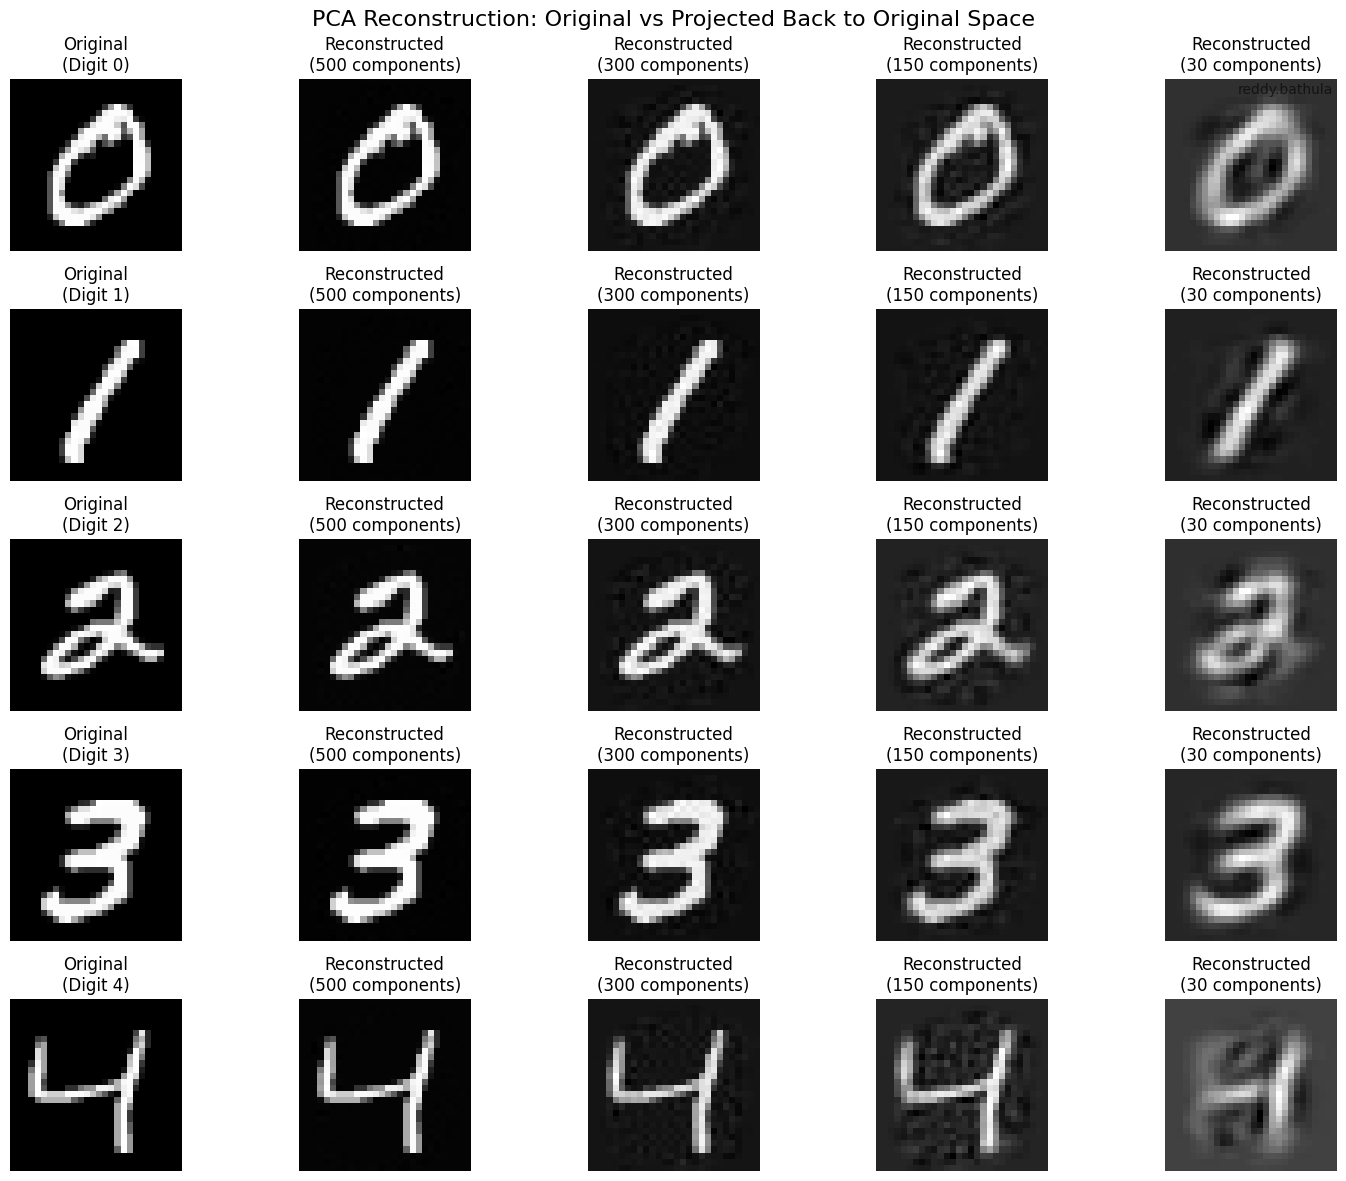

Quantitative Observations:
📉 500 components: 36.2% dimensionality reduction
📉 300 components: 61.7% dimensionality reduction
📉 150 components: 80.9% dimensionality reduction
📉 30 components: 96.2% dimensionality reduction


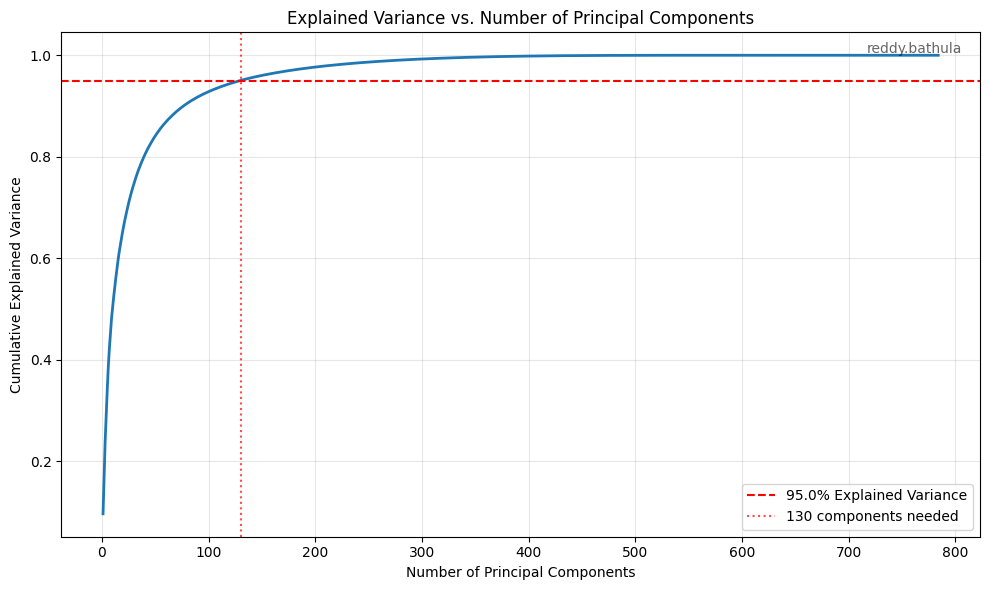

In [68]:
target_dims = [500, 300, 150, 30]
sample_indices = [0, 100, 200, 300, 400]
X_balanced, y_balanced = load_mnist_preprocess()
pca_viz = PCAVisualizer(X_balanced, y_balanced, image_shape=(28, 28))
pca_viz.visualize_reconstruction_assignment(target_dims, sample_indices)
components_needed = pca_viz.plot_explained_variance(max_components=784, threshold=0.95)


Qualitative Observations:
- 500 components: Excellent reconstruction, nearly identical to original
- 300 components: Very good quality, minor loss of fine details
- 150 components: Good quality, some blurring visible
- 30 components: Recognizable but significantly blurred, loss of fine features
- The trade-off between compression and quality is clearly visible!